In [1]:
# Reentry simulation driver notebook
import numpy as np
import re
import math
import matplotlib.pyplot as plt

import constants
import StochasticEntrySim.math_3d as math_3d


ModuleNotFoundError: No module named 'StochasticEntrySim'

In [2]:
def parse_input_file(input_path: str):
    """
    Parse a simple key = value input file into a dictionary.
    Lines starting with # or blank lines are ignored.
    Numeric values (including negatives and scientific notation)
    are converted to float; everything else is kept as string.
    """
    state_dict = {}

    with open(input_path, "r") as file:
        input_list = file.readlines()

    extract_pattern = r"^\s*([A-Za-z_]\w*)\s*=\s*([^#\n]+)"
    num_pattern = re.compile(r"^[+-]?\d+(\.\d+)?([eE][+-]?\d+)?$")

    for line in input_list:
        stripped = line.strip()
        if not stripped or stripped.startswith("#"):
            continue

        m = re.match(extract_pattern, line)
        if not m:
            continue

        key = m.group(1)
        raw_value = m.group(2).strip()

        if num_pattern.fullmatch(raw_value):
            try:
                value = float(raw_value)
                state_dict[key] = value
            except ValueError:
                state_dict[key] = raw_value
        else:
            state_dict[key] = raw_value

    return state_dict


In [3]:
def constant_bank_sigma_fn_builder(state_dict):
    """Build a sigma(t, x) function from state_dict (constant bank angle)."""
    sigma_const_deg = state_dict.get("sigma_const_deg", 0.0)
    sigma_const_rad = float(sigma_const_deg) * math.pi / 180.0

    def sigma_fn(t, x):
        return sigma_const_rad

    return sigma_fn


In [ ]:
# Path to your input file (make sure this notebook is in the same folder)
input_path = "input.txt"

state_dict = parse_input_file(input_path)
print("Parsed input keys:", state_dict.keys())

# Vehicle and aero parameters
params = {
    "m": float(state_dict.get("mass_kg", 2000.0)),
    "S": float(state_dict.get("ref_area_m2", 15.0)),
    "CD": float(state_dict.get("CD_const", 1.0)),
    "CL": float(state_dict.get("CL_const", 0.3)),
}

# Initial state x = [r, phi, lam, V, gamma, chi]
h0 = float(state_dict.get("init_altitude_m", 120000.0))
r0 = constants.RADIUS_EARTH + h0

phi0_deg = float(state_dict.get("init_lat_deg", 0.0))
lam0_deg = float(state_dict.get("init_lon_deg", 0.0))
V0 = float(state_dict.get("init_speed_mps", 7700.0))
gamma0_deg = float(state_dict.get("init_fpa_deg", -5.0))
chi0_deg = float(state_dict.get("init_heading_deg", 90.0))

phi0 = phi0_deg * math.pi / 180.0
lam0 = lam0_deg * math.pi / 180.0
gamma0 = gamma0_deg * math.pi / 180.0
chi0 = chi0_deg * math.pi / 180.0

x0 = [r0, phi0, lam0, V0, gamma0, chi0]

# Time settings
t0 = float(state_dict.get("t0_s", 0.0))
t_final = float(state_dict.get("t_final_s", 2000.0))
dt = float(state_dict.get("dt_s", 0.25))

sigma_fn = constant_bank_sigma_fn_builder(state_dict)

# Stopping conditions
min_altitude = float(state_dict.get("min_altitude_m", 0.0))
min_speed = float(state_dict.get("min_speed_mps", 10.0))

# Integrate with simple Euler
t = t0
x = x0[:]
history = []

while t <= t_final:
    h = math_3d.altitude(x[0])
    V = x[3]

    if h <= min_altitude or V <= min_speed:
        break

    history.append((t, *x))
    dx = math_3d.eom_3d(t, x, params, sigma_fn)
    dx = [float(d) for d in dx]
    x = [xi + dt * dxi for xi, dxi in zip(x, dx)]
    t += dt

len(history)


Parsed input keys: dict_keys(['case_name', 't0_s', 'dt_s', 't_final_s', 'output_stride', 'min_altitude_m', 'max_altitude_m', 'min_speed_mps', 'init_altitude_m', 'init_lat_deg', 'init_lon_deg', 'init_speed_mps', 'init_fpa_deg', 'init_heading_deg', 'mass_kg', 'ref_area_m2', 'CL_const', 'CD_const', 'nose_radius_m', 'mu_m3s2', 'R_E_m', 'rho0_kgm3', 'H_m', 'bank_profile', 'sigma_const_deg', 'use_heating', 'use_J2', 'use_winds'])


530

[120.         119.8322252  119.66442633 119.49660342 119.32875648
 119.16088552 118.99299055 118.82507159 118.65712865 118.48916175
 118.32117089 118.15315609 117.98511737 117.81705474 117.64896821
 117.48085779 117.3127235  117.14456536 116.97638336 116.80817754
 116.6399479  116.47169445 116.30341722 116.1351162  115.96679142
 115.7984429  115.63007063 115.46167464 115.29325494 115.12481154
 114.95634446 114.78785371 114.6193393  114.45080125 114.28223957
 114.11365427 113.94504538 113.77641289 113.60775683 113.4390772
 113.27037403 113.10164732 112.93289709 112.76412336 112.59532613
 112.42650541 112.25766124 112.0887936  111.91990253 111.75098803
 111.58205012 111.41308881 111.24410411 111.07509604 110.90606462
 110.73700984 110.56793174 110.39883032 110.22970559 110.06055757
 109.89138628 109.72219172 109.55297392 109.38373287 109.21446861
 109.04518113 108.87587046 108.70653661 108.53717959 108.36779941
 108.1983961  108.02896965 107.8595201  107.69004744 107.5205517
 107.3510328

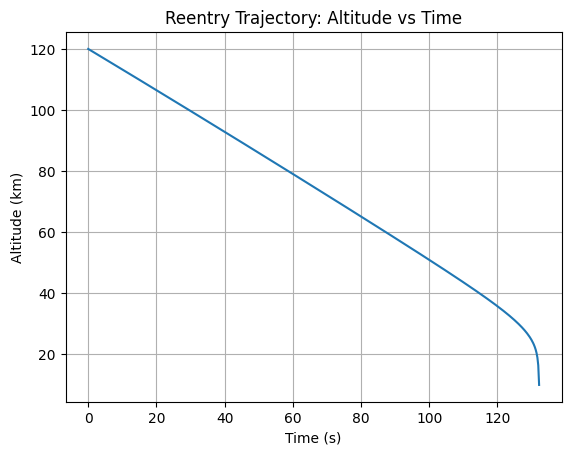

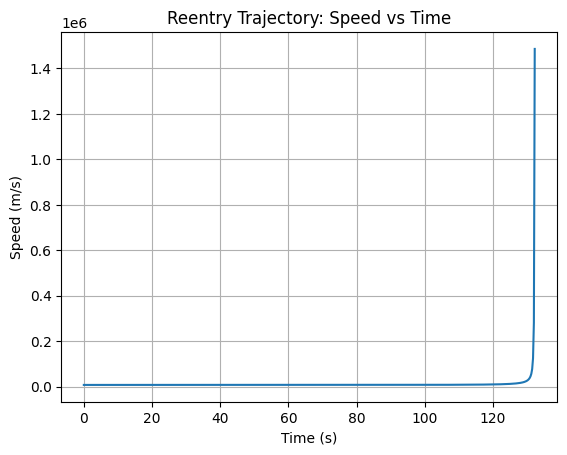

In [6]:
# Convert history to arrays and plot
if len(history) == 0:
    print("No trajectory points recorded. Check initial conditions or dt.")
else:
    history_arr = np.array(history)
    t_arr = history_arr[:, 0]
    r_arr = history_arr[:, 1]
    V_arr = history_arr[:, 4]

    h_arr = (r_arr - constants.RADIUS_EARTH) / 1000.0

    print(h_arr)

    plt.figure()
    plt.plot(t_arr, h_arr)
    plt.xlabel("Time (s)")
    plt.ylabel("Altitude (km)")
    plt.title("Reentry Trajectory: Altitude vs Time")
    plt.grid(True)

    plt.figure()
    plt.plot(t_arr, V_arr)
    plt.xlabel("Time (s)")
    plt.ylabel("Speed (m/s)")
    plt.title("Reentry Trajectory: Speed vs Time")
    plt.grid(True)

    plt.show()
